# Stage 02: Exploratory Data Analysis (Part 2)

## Lexical Analysis (Word Level)

### Load Dataset

In [95]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer 
from collections import Counter, defaultdict
from wordcloud import WordCloud
import math
import re

train_path = Path("../data/processed/pcl_task1_train.csv")
dev_path = Path("../data/processed/pcl_task1_dev.csv")

train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuakilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### N-gram analysis

In [96]:
def top_ngrams(texts, n=2, k=20, is_df=False):
    # Stop words added back to see how sentence is constructed in higher n-grams
    stop_words = None if n > 2 else "english"
    min_df = 3 if n > 2 else 5

    vec = CountVectorizer(ngram_range=(n,n), stop_words=stop_words, min_df=min_df)
    X = vec.fit_transform(texts)
    counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    if is_df:
        df = pd.DataFrame({"ngram": vocab, "count": counts})
        return df.sort_values("count", ascending=False).head(k)
    return sorted(zip(vocab, counts), key=lambda x: -x[1])[:k]

def diff_ngrams(pos_texts, neg_texts, n=2, k=None, normalize=False, both=False, min_df=None):
    stop_words = None if n > 2 else "english"
    min_df = min_df if min_df is not None else (3 if n > 2 else 5)

    vec = CountVectorizer(ngram_range=(n,n), stop_words=stop_words, min_df=min_df)
    X = vec.fit_transform(pd.concat([pos_texts, neg_texts]))
    vocab = vec.get_feature_names_out()

    pos_counts = X[:len(pos_texts)].sum(axis=0).A1
    neg_counts = X[len(pos_texts):].sum(axis=0).A1

    if normalize:
        # if data is unbalanced
        # P(word | PCL) / P(word | non-PCL)   
            # with Laplace smoothing
        pos_freq = (pos_counts + 1) / (pos_counts.sum() + len(vocab))
        neg_freq = (neg_counts + 1) / (neg_counts.sum() + len(vocab))
        score = pos_freq / neg_freq
    else:
        # raw ratio
        score = (pos_counts + 1) / (neg_counts + 1)

    df = pd.DataFrame({"ngram": vocab, "ratio": score}).sort_values("ratio", ascending=False)
    size = len(df)
    k = k if k is not None else size if not both else size // 2

    if both:
        return df.head(k), df.tail(k).sort_values("ratio", ascending=True)
    return df.head(k)

def plot_top_ngrams(train_df, n=2, k=20, normalize=False):
    pos = train_df.loc[train_df.label_bin==1, "text"]
    neg = train_df.loc[train_df.label_bin==0, "text"]
    name = "Unigrams" if n==1 else "Bigrams" if n==2 else f"{n}-grams"

    top_df, bottom_df = diff_ngrams(pos, neg, n, k, normalize, both=True)
    bottom_df = bottom_df.copy()
    bottom_df["ratio"] = 1 / bottom_df["ratio"]  # invert for readability

    plots = [
        (f"Top PCL {name}", top_ngrams(pos, n, k, True), "count", "count"),
        (f"Top Non-PCL {name}", top_ngrams(neg, n, k, True), "count", "count"),
        (f"{name} Most Indicative of PCL", top_df, "ratio", "Likelihood ratio (higher = stronger association with PCL)"),
        (f"{name} Most Indicative of Non-PCL", bottom_df, "ratio", "Likelihood ratio (higher = stronger association with Non-PCL)"),
    ]

    for title, df, xcol, xlabel in plots:
        plt.figure(figsize=(8,5))   
        sns.barplot(data=df, y="ngram", x=xcol)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.show()

- P(word | PCL) / P(word | non-PCL)   for likelihood ratio to correct class imbalance

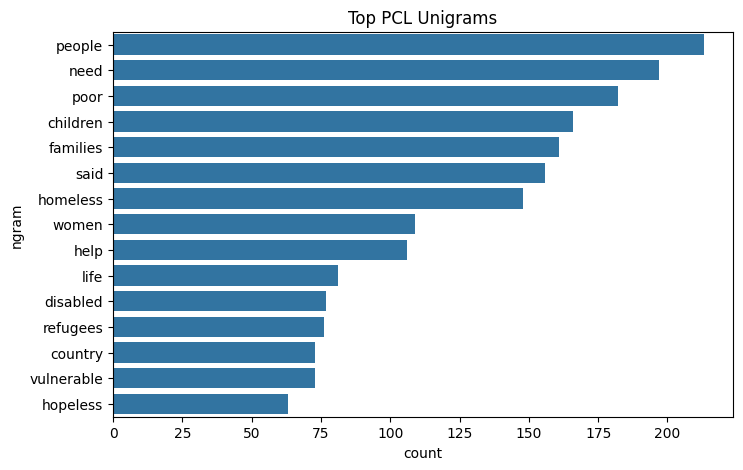

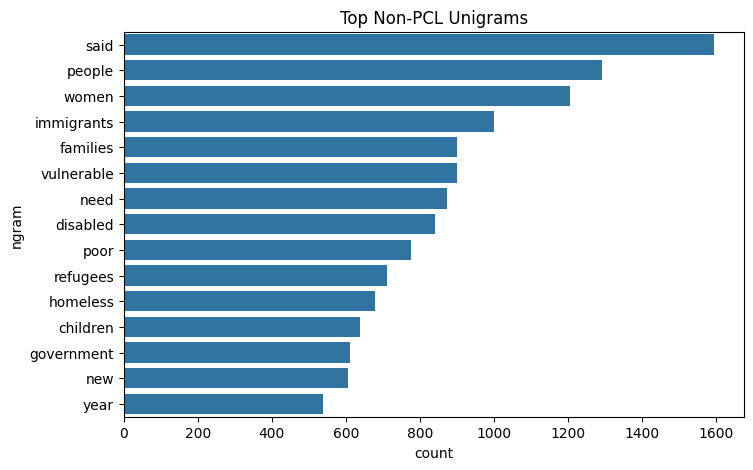

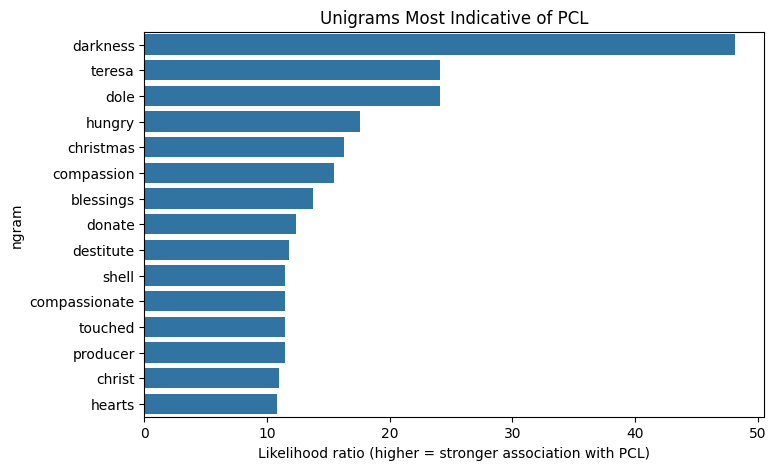

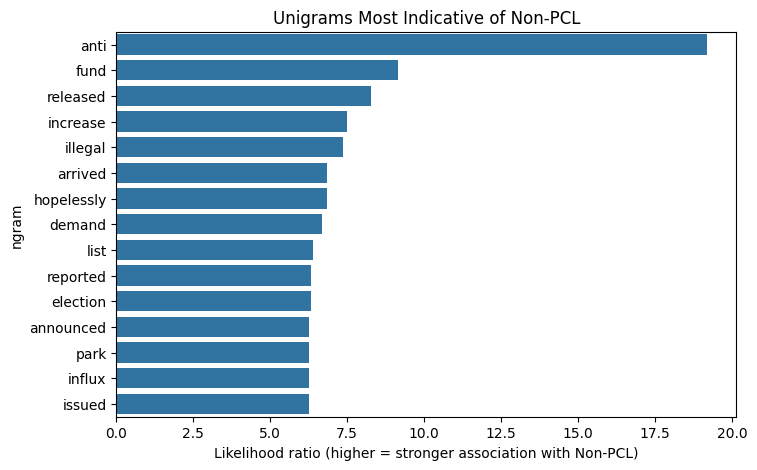

In [97]:
plot_top_ngrams(train_df, n=1, k=15, normalize=True)

- For unigram some very particular words had very strong indication of PCL (10x to 50x more likely)
- darkness is 48x more likely to appear in a PCL paragraph than a non-PCL paragraph

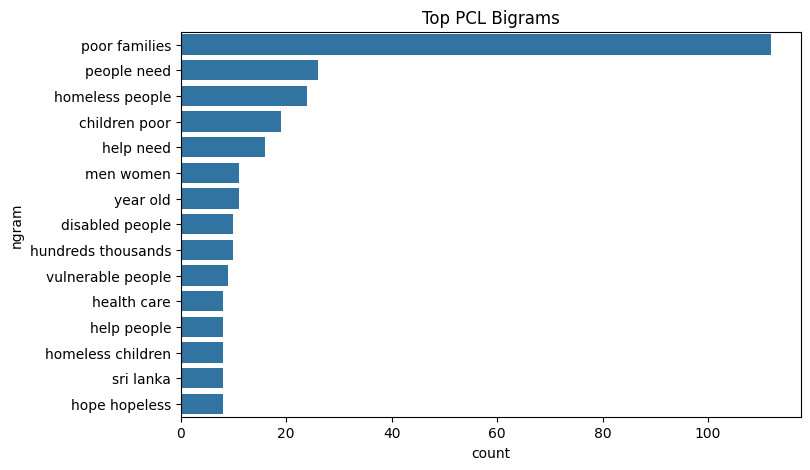

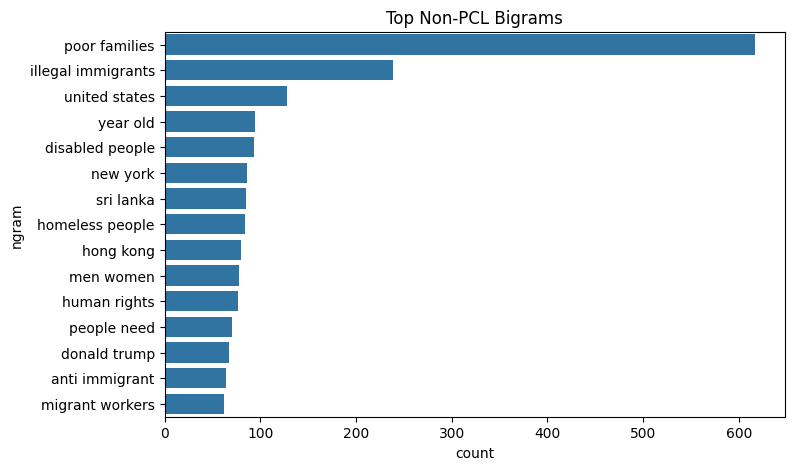

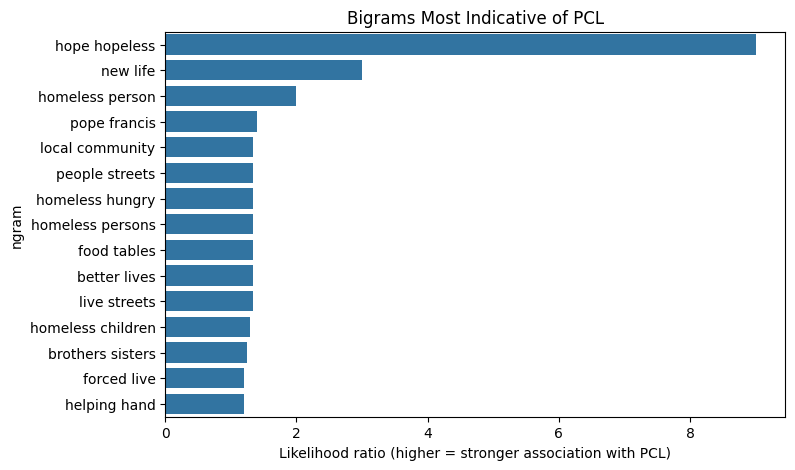

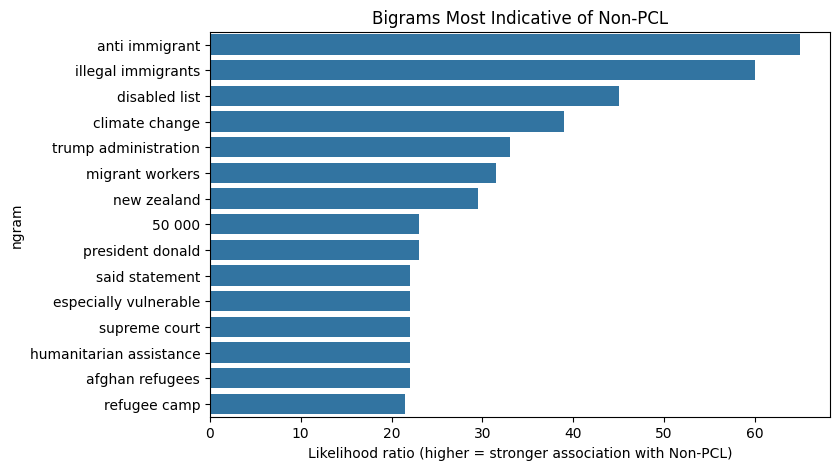

In [98]:
plot_top_ngrams(train_df, n=2, k=15)

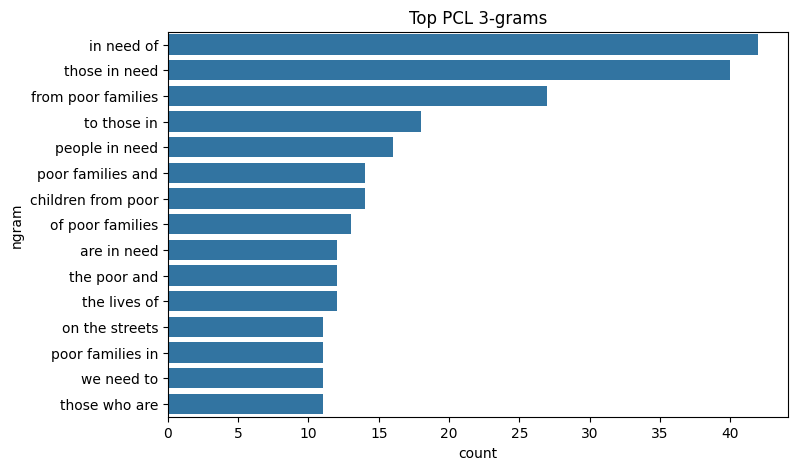

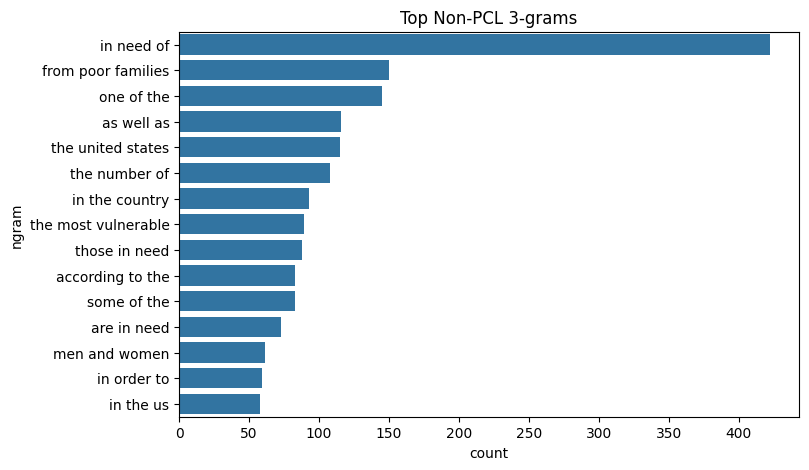

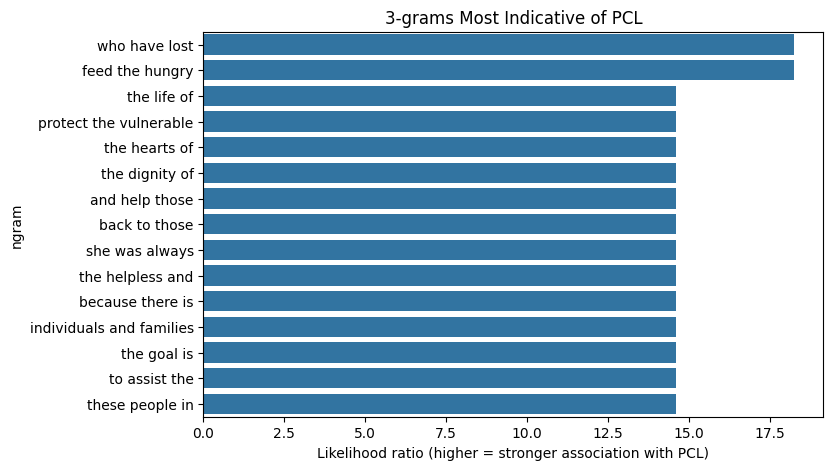

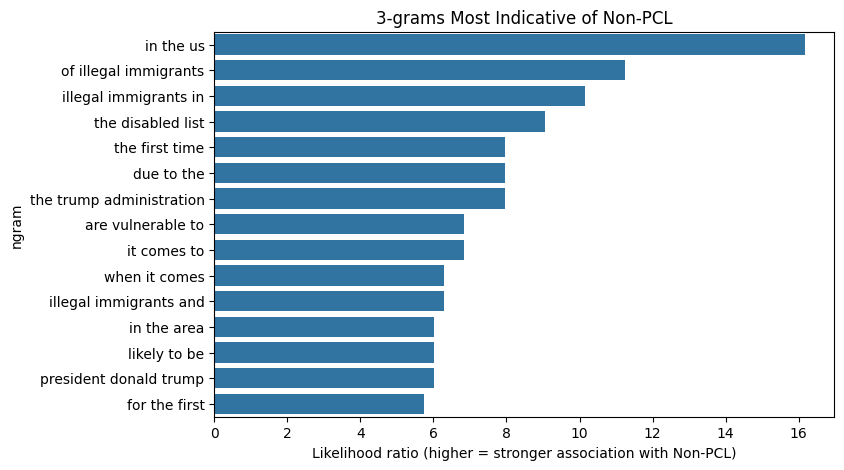

In [99]:
plot_top_ngrams(train_df, n=3, k=15, normalize=True)

### Simple Naive Bayes PCL classifier utilising n-gram ratios

We classify a document $d = (w_1,\dots,w_n)$ as PCL using Bayes' rule:

$$
\frac{P(\mathrm{PCL}\mid d)}{P(\mathrm{nonPCL}\mid d)}
=
\frac{P(\mathrm{PCL})}{P(\mathrm{nonPCL})}
\prod_{i=1}^{n}
\frac{P(w_i\mid \mathrm{PCL})}{P(w_i\mid \mathrm{nonPCL})}
$$

Taking the logarithm gives an additive scoring function:

$$
\log \frac{P(\mathrm{PCL}\mid d)}{P(\mathrm{nonPCL}\mid d)}
=
\log \frac{P(\mathrm{PCL})}{P(\mathrm{nonPCL})}
+
\sum_{i=1}^{n}
\log \frac{P(w_i\mid \mathrm{PCL})}{P(w_i\mid \mathrm{nonPCL})}
$$

We predict PCL if this score is greater than 0.

In [100]:
def build_log_evidence_from_diff(
    train_df,
    text_col="text",
    label_col="label_bin",
    n=1,                 # default unigrams
    min_df=None,         # uses diff_ngram default if None
    min_abs=0.25,        # ignore near-neutral features ln(1.3)
    clip=3.8,            # cap extreme evidence (ln(45))
    use_prior=True       # include log(P(pos)/P(neg))
):
    pos = train_df.loc[train_df[label_col] == 1, text_col].reset_index(drop=True)
    neg = train_df.loc[train_df[label_col] == 0, text_col].reset_index(drop=True)

    # Full vocab table (k=None) using your diff_ngrams
    df = diff_ngrams(pos, neg, n=n, k=None, normalize=True, both=False, min_df=min_df)
    # df columns: ngram, ratio (sorted)

    # Convert ratio -> log-ratio evidence
    df = df.copy()
    df["log_ratio"] = np.log(df["ratio"].astype(float))

    # Threshold & clip
    df = df.loc[df["log_ratio"].abs() >= min_abs].copy()
    df["log_ratio"] = df["log_ratio"].clip(-clip, clip)

    log_ratio = dict(zip(df["ngram"], df["log_ratio"]))

    if use_prior:
        p_pos = (train_df[label_col] == 1).mean()
        log_prior_ratio = float(np.log((p_pos + 1e-12) / (1 - p_pos + 1e-12)))
    else:
        log_prior_ratio = 0.0

    meta = {
        "n": n,
        "min_df": min_df,
        "min_abs": min_abs,
        "clip": clip,
        "use_prior": use_prior,
        "features_kept": len(log_ratio),
    }
    return log_ratio, log_prior_ratio, meta

In [101]:
def score_texts_presence(
    texts,
    log_ratio,
    log_prior_ratio=0.0,
    n=1
):
    feats = list(log_ratio.keys())

    # Match your preprocessing choices inside diff_ngrams:
    stop_words = None if n > 2 else "english"

    vec = CountVectorizer(
        ngram_range=(n, n),
        stop_words=stop_words,
        vocabulary=feats,
        binary=True
    )

    X = vec.transform(texts)
    weights = np.array([log_ratio[f] for f in vec.get_feature_names_out()])

    scores = X @ weights
    scores = np.asarray(scores).ravel() 

    return scores + log_prior_ratio

In [102]:
def predict_from_scores(scores, threshold=0.0):
    return (scores > threshold).astype(int)

def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float((y_true == y_pred).mean())

def precision_recall_f1(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    tp = ((y_true==1) & (y_pred==1)).sum()
    fp = ((y_true==0) & (y_pred==1)).sum()
    fn = ((y_true==1) & (y_pred==0)).sum()
    tn = ((y_true==0) & (y_pred==0)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    pcl_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    nonpcl_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1, pcl_acc, nonpcl_acc

def confusion(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = int(((y_true==1) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    return {"TP": tp, "TN": tn, "FP": fp, "FN": fn}

In [111]:
log_ratio, log_prior_ratio, meta = build_log_evidence_from_diff(
    train_df,
    n=1,          # unigrams
    min_df=5,     # or None to use your default rule
    min_abs=0.25, # ln(1.3)
    clip=4, #ln 55
    use_prior=True
)

print(meta)

dev_texts = dev_df.dropna(subset=["text"]).copy()
train_df["text"] = train_df["text"].fillna("").astype(str)
dev_scores = score_texts_presence(
    dev_texts["text"].astype(str).tolist(),
    log_ratio,
    log_prior_ratio,
    n=1
)

dev_preds = predict_from_scores(dev_scores, threshold=0.0)
precision, recall, f1, pcl_acc, nonpcl_acc = precision_recall_f1(dev_texts["label_bin"], dev_preds)

print("Dev accuracy:", accuracy(dev_texts["label_bin"], dev_preds))
print("Dev confusion:", confusion(dev_texts["label_bin"], dev_preds))
print("Dev precision/recall/f1:", precision, recall, f1)
print("PCL class accuracy:", pcl_acc)
print("non-PCL class accuracy:", nonpcl_acc)

{'n': 1, 'min_df': 5, 'min_abs': 0.25, 'clip': 4, 'use_prior': True, 'features_kept': 3926}
Dev accuracy: 0.8805542283803154
Dev confusion: {'TP': 63, 'TN': 1780, 'FP': 114, 'FN': 136}
Dev precision/recall/f1: 0.3559322033898305 0.3165829145728643 0.3351063829787234
PCL class accuracy: 0.3165829145728643
non-PCL class accuracy: 0.9398099260823654


In [112]:
def explain_doc(text, log_ratio, log_prior_ratio=0.0, n=1, top_k=15):
    stop_words = None if n > 2 else "english"
    feats = list(log_ratio.keys())

    vec = CountVectorizer(
        ngram_range=(n, n),
        stop_words=stop_words,
        vocabulary=feats,
        binary=True
    )

    X = vec.transform([text])
    names = vec.get_feature_names_out()

    present_idx = X.nonzero()[1]
    contribs = [(names[i], float(log_ratio[names[i]])) for i in present_idx]
    contribs.sort(key=lambda x: abs(x[1]), reverse=True)

    score = log_prior_ratio + sum(v for _, v in contribs)
    pred = 1 if score > 0 else 0

    return {
        "score": float(score),
        "pred": int(pred),
        "top_contribs": contribs[:top_k]
    }

# Example:
explain_doc(dev_df.iloc[5]["text"], log_ratio, log_prior_ratio, n=1)

{'score': 3.1924696624254416,
 'pred': 1,
 'top_contribs': [('compassionate', 2.439259522229546),
  ('generous', 1.746112341669601),
  ('refuge', 1.0121431665894007),
  ('region', -0.8849768182964807),
  ('bangladesh', -0.8596590103121907),
  ('respond', 0.8298216097954461),
  ('responsibility', 0.7244610941376198),
  ('acted', 0.542139537343665),
  ('provide', 0.4754481628449929),
  ('need', 0.44247704280047656),
  ('said', -0.3912024444031486),
  ('government', -0.33104795411298377),
  ('host', -0.29618965306077816)]}

### Word clouds & frequency

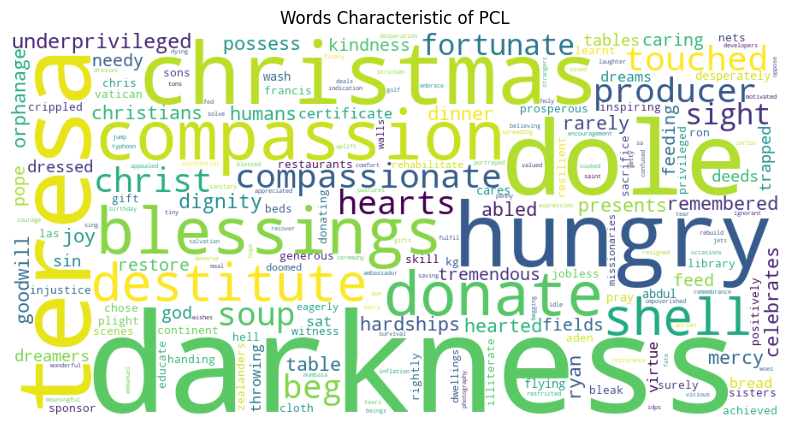

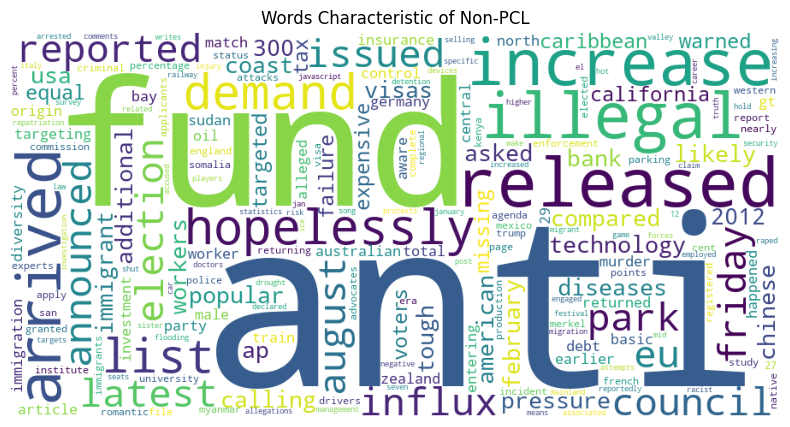

In [105]:
def ratio_weights(pos_texts, neg_texts, top_k=200, normalize=True):
    top_df, _ = diff_ngrams(pos_texts, neg_texts, n=1, k=top_k, normalize=normalize, both=True)
    return dict(zip(top_df["ngram"], top_df["ratio"]))

def ratio_weights_non(pos_texts, neg_texts, top_k=200, normalize=True):
    top_df, _ = diff_ngrams(neg_texts, pos_texts, n=1, k=top_k, normalize=normalize, both=True)
    return dict(zip(top_df["ngram"], top_df["ratio"]))

def plot_weighted_cloud(weights, title):
    wc = WordCloud(width=900, height=450, background_color="white")
    wc.generate_from_frequencies(weights)

    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()

pos_texts = train_df.loc[train_df.label_bin==1, "text"]
neg_texts = train_df.loc[train_df.label_bin==0, "text"]

plot_weighted_cloud(ratio_weights(pos_texts, neg_texts), "Words Characteristic of PCL")
plot_weighted_cloud(ratio_weights_non(pos_texts, neg_texts), "Words Characteristic of Non-PCL")

- notice how non-pcl prevelant words are words used in news reporting
- notice how pcl relveant words are emotive words (to evoke feelings not describe facts)
- informational reporting vs sentimental framing

### Stop word density

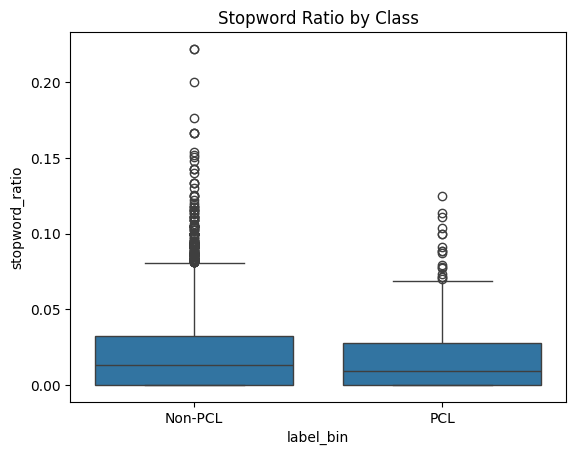

In [106]:
stop_words = set(stopwords.words("english"))
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def stopword_ratio(text):
    tokens = tokenizer.tokenize(text.lower())
    if len(tokens) == 0:
        return 0
    return sum(t in stop_words for t in tokens) / len(tokens)

train_df["stopword_ratio"] = train_df["text"].apply(stopword_ratio)

sns.boxplot(x="label_bin", y="stopword_ratio", data=train_df)
plt.xticks([0,1], ["Non-PCL", "PCL"])
plt.title("Stopword Ratio by Class")
plt.show()

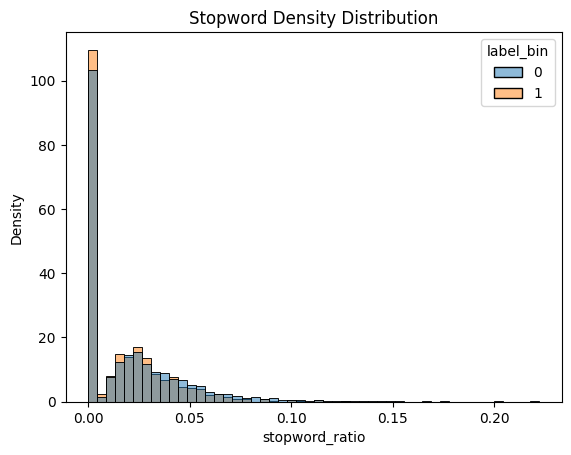

In [107]:
sns.histplot(data=train_df, x="stopword_ratio", hue="label_bin", bins=50, stat="density", common_norm=False)
plt.title("Stopword Density Distribution")
plt.show()

- basically no difference
- this informs us that the difference is not in structural language use but in lexical & pragmatic meaning
- thus the model is very unlikely to try to use this as a shortcut feature - good!
- also shows not much cleanup is requied since stopwords make a small part 